# Assignment - Recurrent Neural Networks

1. Using the pip install yfinance command as shown in the lesson, select 2 different stocks to be decided by yourself and estimate the future prices of these stocks using LSTM (1-step forecast).


2. Briefly discuss the problems encountered in RNN and why LSTM is needed.


3. Find out what the epoch and batch size parameters are in LSTM. Resolve the 1st question with different values of epoch and batch size, and report the result.

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore') 

In [2]:
df_msft = yf.download('MSFT', start = '2018-01-01', end = '2020-01-01', interval='1d', prepost=True)
df_aapl = yf.download('AAPL', start = '2018-01-01', end = '2020-01-01', interval='1d', prepost=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_msft["Average"] = (df_msft["High"] + df_msft["Low"])/2
df_aapl["Average"] = (df_aapl["High"] + df_aapl["Low"])/2

In [4]:
df_msft.head()

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,86.129997,86.309998,85.500000,85.949997,82.004974,22483800,85.904999
2018-01-03,86.059998,86.510002,85.970001,86.349998,82.386620,26061400,86.240002
2018-01-04,86.589996,87.660004,86.570000,87.110001,83.111740,21912000,87.115002
2018-01-05,87.660004,88.410004,87.430000,88.190002,84.142174,23407100,87.920002
2018-01-08,88.199997,88.580002,87.599998,88.279999,84.228027,22113000,88.090000


In [5]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,Average
Date,,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,41.310070,102223600,42.695000
2018-01-03,43.132500,43.637501,42.990002,43.057499,41.302879,118071600,43.313751
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.494736,89738400,43.193750
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.967163,94640000,43.552500
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.811283,82271200,43.692499


In [6]:
def plot_yf(title, df):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.lineplot(x = df.index, y = df["Volume"])
    plt.title(str(title) + " Volume & Date")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.xticks(rotation = 45)

    plt.subplot(122)
    sns.lineplot(x = df.index, y = df["Average"])
    plt.title(str(title) + " Average Prices")
    plt.xlabel("Date")
    plt.ylabel("Average Price")
    plt.xticks(rotation = 45)

    plt.show()

In [7]:
def prep_data(input_data, df):
    sc= MinMaxScaler(feature_range=(0,1))
    input_data[:,0:2] = sc.fit_transform(input_data[:,:])
    
    lookback= 50

    test_size=int(.3 * len(df))
    X=[]
    y=[]
    for i in range(len(df)-lookback-1):
        t=[]
        for j in range(0,lookback):
            t.append(input_data[[(i+j)], :])
        X.append(t)
        y.append(input_data[i+ lookback,1])
        
    X, y= np.array(X), np.array(y)
    X_test = X[:test_size + lookback]
    X = X.reshape(X.shape[0], lookback, 2)
    X_test = X_test.reshape(X_test.shape[0], lookback, 2)
    print(X.shape)
    print(X_test.shape)
    
    return X, y, X_test, test_size

In [8]:
def plot_predictions(predictions, input_data, test_size):
    lookback=50
    plt.figure(figsize=(12, 8))
    plt.plot(predictions, color= 'red')
    plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
    plt.title("Share Prices and Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(['Prediction','True'])
    plt.show()

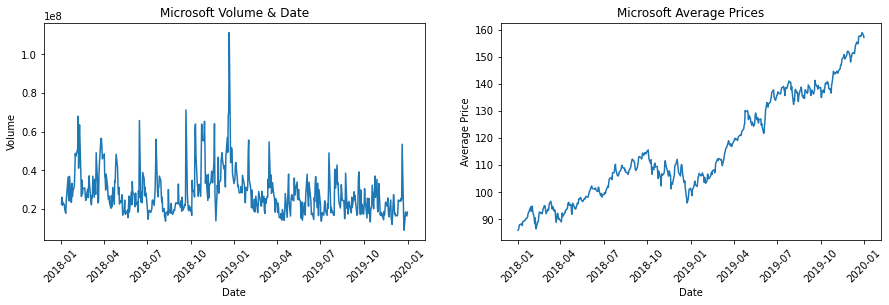

In [9]:
plot_yf("Microsoft", df_msft)

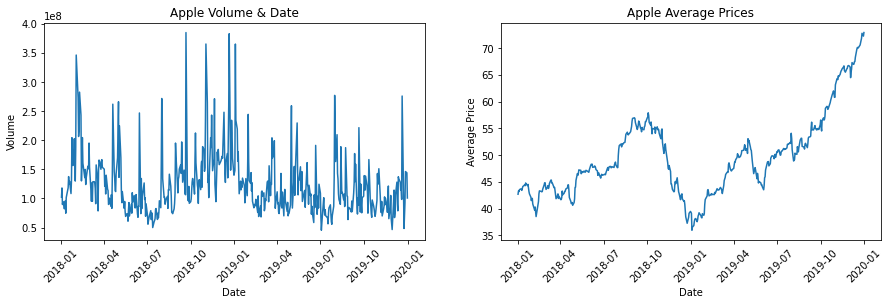

In [10]:
plot_yf("Apple", df_aapl)

LSTMs are very powerful in sequence prediction problems because they’re able to store past information. This is important in our case because the previous price of a stock is crucial in predicting its future price.

In [11]:
input_data_msft = df_msft.iloc[:,[5,6]].values

X_msft, y_msft, X_test_msft, test_size_msft = prep_data(input_data_msft, df_msft)

(452, 50, 2)
(200, 50, 2)


In [12]:
model_msft = Sequential()
model_msft.add(LSTM(units=32, return_sequences= True, input_shape=(X_msft.shape[1],2)))
model_msft.add(LSTM(units=32, return_sequences=True))
model_msft.add(LSTM(units=18))
model_msft.add(Dense(units=1))
model_msft.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 32)            4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 18)                3672      
_________________________________________________________________
dense (Dense)                (None, 1)                 19        
Total params: 16,491
Trainable params: 16,491
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_msft.compile(optimizer='adam', loss='mean_squared_error')
model_msft.fit(X_msft, y_msft, epochs=100, batch_size=16, verbose=0)

In [14]:
predictions_msft = model_msft.predict(X_test_msft)

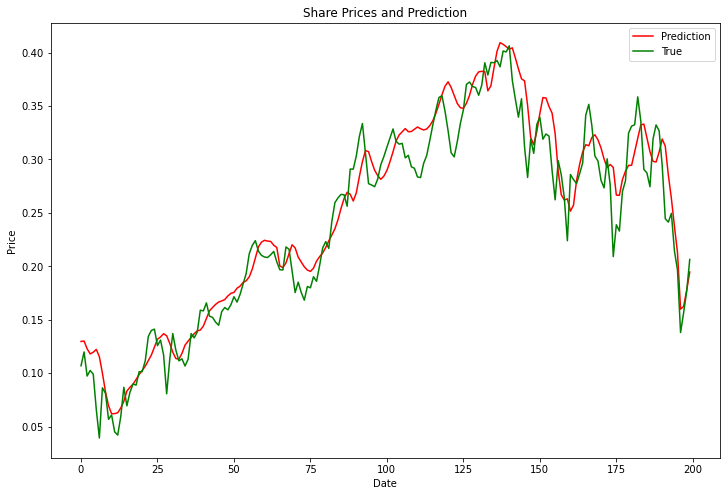

In [15]:
plot_predictions(predictions_msft, input_data_msft, test_size_msft)

In [16]:
input_data_aapl = df_aapl.iloc[:,[5,6]].values

X_aapl, y_aapl, X_test_aapl, test_size_aapl = prep_data(input_data_aapl, df_aapl)

(452, 50, 2)
(200, 50, 2)


In [17]:
model_aapl = Sequential()
model_aapl.add(LSTM(units=50, return_sequences= True, input_shape=(X_aapl.shape[1], 2)))
model_aapl.add(LSTM(units=25, return_sequences= True))
model_aapl.add(LSTM(units=25))
model_aapl.add(Dense(units=1))
model_aapl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 25)            7600      
_________________________________________________________________
lstm_5 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 23,326
Trainable params: 23,326
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_aapl.compile(optimizer='adam', loss='mean_squared_error')
model_aapl.fit(X_aapl, y_aapl, epochs=50, batch_size=16, verbose=0)

In [19]:
predictions_aapl = model_aapl.predict(X_test_aapl)

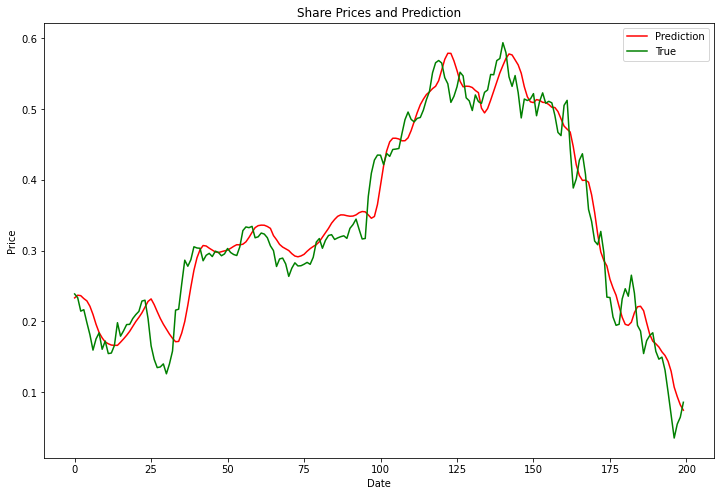

In [20]:
plot_predictions(predictions_aapl, input_data_aapl, test_size_aapl)

As we can see, our models didn't perform well on our datasets but we can improve that with different parameters.

## Resolving the 1st question with different values of epoch and batch size

In [21]:
model_msft2 = Sequential()
model_msft2.add(LSTM(units=50, return_sequences= True, input_shape=(X_msft.shape[1],2)))
model_msft2.add(LSTM(units=75, return_sequences=True))
model_msft2.add(LSTM(units=100))
model_msft2.add(Dense(units=1))
model_msft2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 50)            10600     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 75)            37800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               70400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 118,901
Trainable params: 118,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_msft2.compile(optimizer='adam', loss='mean_squared_error')
model_msft2.fit(X_msft, y_msft, epochs=200, batch_size=16, verbose=0)

In [23]:
predictions_msft2 = model_msft2.predict(X_test_msft)

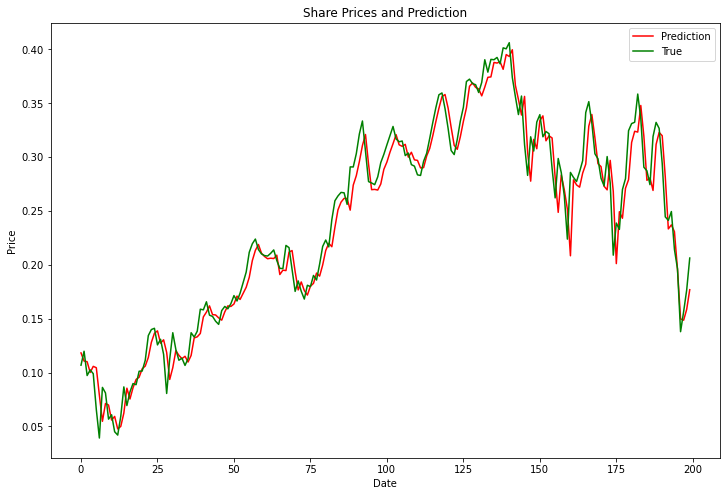

In [24]:
plot_predictions(predictions_msft2, input_data_msft, test_size_msft)

In [25]:
model_aapl2 = Sequential()
model_aapl2.add(LSTM(units=50, return_sequences= True, input_shape=(X_aapl.shape[1], 2)))
model_aapl2.add(LSTM(units=50, return_sequences= True))
model_aapl2.add(LSTM(units=100))
model_aapl2.add(Dense(units=1))
model_aapl2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 50)            10600     
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 50)            20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 91,301
Trainable params: 91,301
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_aapl2.compile(optimizer='adam', loss='mean_squared_error')
model_aapl2.fit(X_aapl, y_aapl, epochs=200, batch_size=16, verbose=0)

In [27]:
predictions_aapl2 = model_aapl2.predict(X_test_aapl)

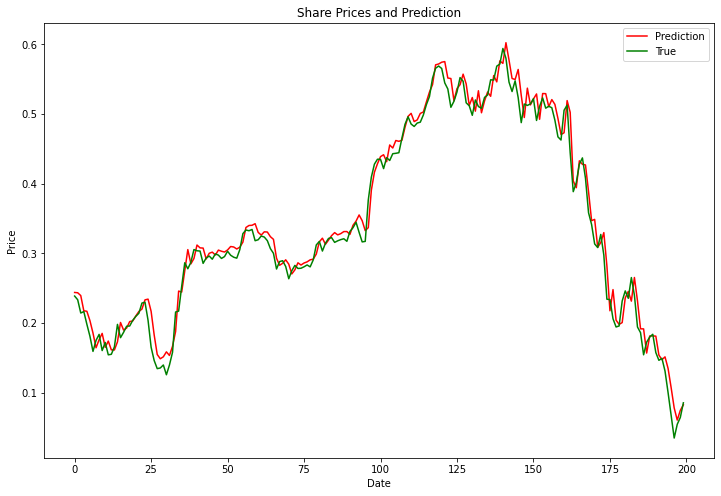

In [28]:
plot_predictions(predictions_aapl2, input_data_aapl, test_size_aapl)

After some adjustments our models predicted the data well. We can say that they became a successful models.